In [1]:
import pandas as pd
import numpy as np
import pickle
#
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#
import seaborn as sns
import plotly.express as px

#
import os
import random
import re
import math
import time

from tqdm import tqdm
from tqdm.keras import TqdmCallback

#from pandas_summary import DataFrameSummary
#from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.preprocessing import image
import sklearn.neighbors._base
import xgboost as xgb

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import warnings
from missingpy import MissForest
from PIL import Image

#load torch library
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models

import torch
from torch.utils.data import DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile
import torch.nn as nn
warnings.filterwarnings('ignore') 
%matplotlib notebook
%matplotlib inline

### Load Data

In [2]:
df = pd.read_csv('./only_split_3.csv', index_col = 0)
df.head()

,age_impute_mf,reds,greens,blues,mean_colors,missing_anatomy,missing_sex,missing_age,age_impute_mode,age_impute_median,...,anatomy_mode_lower extremity,anatomy_mode_neck,anatomy_mode_oral/genital,anatomy_mode_palms/soles,anatomy_mode_scalp,anatomy_mode_torso,anatomy_mode_trunk,anatomy_mode_upper extremity,path,split_3
0,70.0,223.231963,163.819367,177.606848,188.219393,0.0,0.0,0.0,70.0,70.0,...,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,test
1,75.0,193.084081,150.232596,163.569293,168.961990,0.0,0.0,0.0,75.0,75.0,...,0,0,0,0,0,0,0,1,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train
2,70.0,143.451707,108.244748,134.621444,128.772633,0.0,0.0,0.0,70.0,70.0,...,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train
3,60.0,198.290763,169.923607,168.705607,178.973326,0.0,0.0,0.0,60.0,60.0,...,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train
4,75.0,180.339181,155.822085,176.047952,170.736406,0.0,0.0,0.0,75.0,75.0,...,0,0,0,0,0,0,0,1,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train


In [3]:
#create a mapping from labels to a unique integer and vice versa for labelling and prediction later
labels = df['label'].sort_values(ascending=True).unique()
i = 0
idx2class = {} 
class2idx = {}
for tp in labels:
    idx2class[i] = tp
    class2idx[tp] = i
    i += 1
idx2class

{0: 'Benign Marking or Mole',
 1: 'Non-Cancerous Skin Condition',
 2: 'Potentially Malignant Skin Tumors',
 3: 'Toxin, Fungal, Bug, Viral, or Bacterial Infections',
 4: 'Unclassified'}

In [4]:
df['label'] = df['label'].replace(class2idx)
df.head()

,age_impute_mf,reds,greens,blues,mean_colors,missing_anatomy,missing_sex,missing_age,age_impute_mode,age_impute_median,...,anatomy_mode_lower extremity,anatomy_mode_neck,anatomy_mode_oral/genital,anatomy_mode_palms/soles,anatomy_mode_scalp,anatomy_mode_torso,anatomy_mode_trunk,anatomy_mode_upper extremity,path,split_3
0,70.0,223.231963,163.819367,177.606848,188.219393,0.0,0.0,0.0,70.0,70.0,...,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,test
1,75.0,193.084081,150.232596,163.569293,168.961990,0.0,0.0,0.0,75.0,75.0,...,0,0,0,0,0,0,0,1,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train
2,70.0,143.451707,108.244748,134.621444,128.772633,0.0,0.0,0.0,70.0,70.0,...,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train
3,60.0,198.290763,169.923607,168.705607,178.973326,0.0,0.0,0.0,60.0,60.0,...,0,0,0,0,0,0,0,0,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train
4,75.0,180.339181,155.822085,176.047952,170.736406,0.0,0.0,0.0,75.0,75.0,...,0,0,0,0,0,0,0,1,./Data/ISIC_2018/Train/HAM10000_images_part_1_...,train


In [5]:
train = df[~df['split_3'].isin(['test', 'val'])]
val = df[df['split_3'].isin(['val'])]
test = df[df['split_3'].isin(['test'])]
train.shape

(13500, 56)

### Split data

In [6]:
X_meta_train = train.drop(['label', 'split_3', 'path'], axis=1).reset_index().drop('index', axis = 1)
X_img_train = train.path.reset_index().drop('index', axis = 1)
y_train = train.label.reset_index().drop('index', axis = 1)

X_meta_val = val.drop(['label', 'split_3', 'path'], axis=1).reset_index().drop('index', axis = 1)
X_img_val = val.path.reset_index().drop('index', axis = 1)
y_val = val.label.reset_index().drop('index', axis = 1)

X_meta_test = test.drop(['label', 'split_3', 'path'], axis=1).reset_index().drop('index', axis = 1)
X_img_test = test.path.reset_index().drop('index', axis = 1)
y_test = test.label.reset_index().drop('index', axis = 1)

### Baseline test accuracy on saved meta model

In [7]:
meta_mod = pickle.load(open('finalized_meta.sav', 'rb'))
result = meta_mod.score(X_meta_test, y_test)
print(result)

0.48


### Baseline test accuracy on saved image model 1

In [11]:
img_mod1 = torch.load(f'resnet_split3_3e.pt', map_location=torch.device('cpu'))
img_mod2 = torch.load(f'merged_resnet50.pt', map_location=torch.device('cpu'))

In [17]:
# Create a preprocessing pipeline
# preprocess = transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
#         transforms.ToTensor(),
#         transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )])


preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.676, 0.542, 0.519],
        std=[0.290, 0.226, 0.237]
    )])


def image_predict(model, image_paths):
    model.eval()
    y_pred = []
    for file_name in image_paths.iloc[:,0]:
        image = Image.open(file_name).convert('RGB')
        # Pass the image for preprocessing and the image preprocessed
        img_preprocessed = preprocess(image)
        # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
        batch_img_tensor = torch.unsqueeze(img_preprocessed, 0)

        output = model(batch_img_tensor)
        predicted = torch.argmax(output,-1).cpu().numpy()  
        
        y_pred.append(predicted)
    y_pred = pd.DataFrame(y_pred, columns = ['pred'])
    return y_pred

In [18]:
img_mod1_pred = image_predict(img_mod1, X_img_test)
img_mod2_pred = image_predict(img_mod2, X_img_test)
print("image model 1 accuracy ", accuracy_score(y_test, img_mod1_pred))
print("image model 2 accuracy ", accuracy_score(y_test, img_mod2_pred))

image model 1 accuracy  0.6133333333333333
image model 2 accuracy  0.018333333333333333


### Output both models on validation file, which is used as training data for learner model

In [19]:
meta_pred = pd.DataFrame(meta_mod.predict(X_meta_val), columns = ['pred']).reset_index().drop('index', axis = 1)
img_mod1_pred = image_predict(img_mod1, X_img_val)
img_mod2_pred = image_predict(img_mod2, X_img_val)

In [20]:
train_df = pd.concat([y_val, meta_pred, img_mod1_pred, img_mod2_pred], axis = 1)
train_df.columns = ['label', '1' , '2', '3']
train_df

,label,1,2,3
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,2,1
...,...,...,...,...
2695,2,3,1,4
2696,2,3,2,3
2697,2,3,3,3
2698,2,3,1,3


### Train Learner Model

In [21]:
X = train_df.drop(['label'], axis=1)
y = train_df.label
# taking holdout set for validating with stratified y

X_train, X_holdout, y_train, y_holdout = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# 5 fold stratify for cv
cv = StratifiedKFold(5, shuffle=True, random_state=42)

In [22]:
xg = xgb.XGBClassifier(
    n_estimators=750,
    min_child_weight=1.2,
    learning_rate=0.040,
    max_depth=3,
    subsample=0.80,
    colsample_bytree=0.6,
    gamma=0.25,
    random_state=42,
    n_jobs=-1,
    objective='multi:softmax',
    nthread=4
)

estimators = [xg]

In [23]:
# cross validation scheme

def model_check(X_train, y_train, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est in estimators:

        MLA_name = est.__class__.__name__
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X_train,
                                    y_train,
                                    cv=cv,
                                    scoring='accuracy',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index,
                        'Train accuracy'] = cv_results['train_score'].mean()
        model_table.loc[row_index,
                        'Validation accuracy'] = cv_results['test_score'].mean()
        model_table.loc[row_index, 'Validation Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Validation accuracy'],
                            ascending=False,
                            inplace=True)

    return model_table

In [24]:
# display cv results

raw_models = model_check(X_train, y_train, estimators, cv)
display(raw_models)

,Model Name,Train accuracy,Validation accuracy,Validation Std,Time
0,XGBClassifier,0.814468,0.809259,0.007691,2.73795


In [25]:
xg.fit(X_train, y_train)

# predicting on holdout set
y_pred = xg.predict(X_holdout)

# checking results on test set
accuracy_score(y_holdout, y_pred)

0.7888888888888889

### Save the learner model

In [26]:
xg.fit(X, y)
import pickle
model = xg
filename = 'learner.sav'
pickle.dump(model, open(filename, 'wb'))

### Test the ensemble model on test file

In [27]:
learner_mod = pickle.load(open('learner.sav', 'rb'))

In [28]:
meta_pred = pd.DataFrame(meta_mod.predict(X_meta_test), columns = ['pred']).reset_index().drop('index', axis = 1)
img_mod1_pred = image_predict(img_mod1, X_img_test)
img_mod2_pred = image_predict(img_mod2, X_img_test)

In [30]:
ensemble_test_x = pd.concat([meta_pred, img_mod1_pred, img_mod2_pred], axis = 1)
#ensemble_test_x.columns = ['1', '2', '3']
ensemble_pred = learner_mod.predict(ensemble_test_x)
accuracy_score(y_test, ensemble_pred)

0.8083333333333333

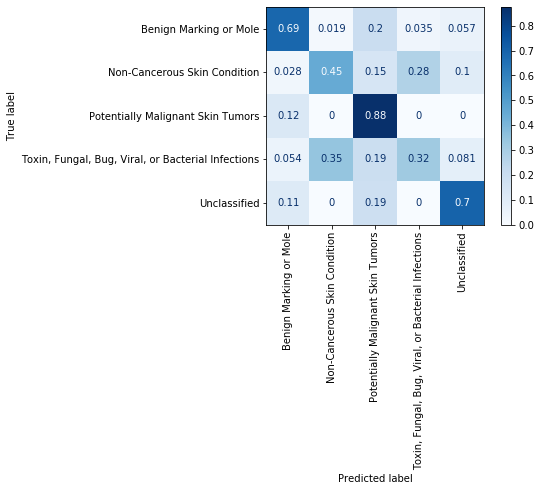

In [32]:
ConfusionMatrixDisplay.from_predictions(meta_pred, y_test, display_labels=[i for i in idx2class.values()], 
                                        xticks_rotation = "vertical", cmap='Blues' , normalize = "true")
plt.show()

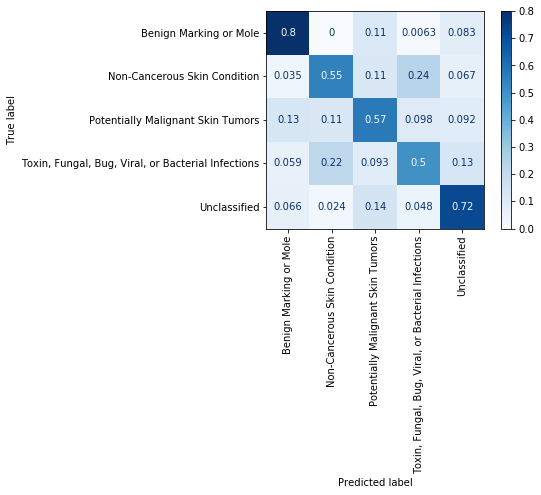

In [33]:
ConfusionMatrixDisplay.from_predictions(img_mod1_pred, y_test, display_labels=[i for i in idx2class.values()], 
                                        xticks_rotation = "vertical", cmap='Blues' , normalize = "true")
plt.show()

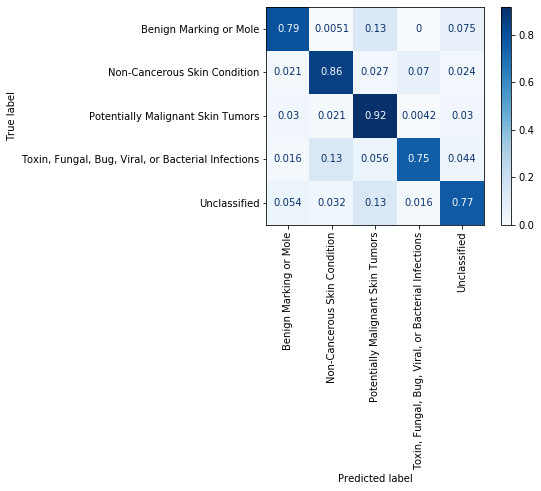

In [31]:
ConfusionMatrixDisplay.from_predictions(ensemble_pred, y_test, display_labels=[i for i in idx2class.values()], 
                                        xticks_rotation = "vertical", cmap='Blues' , normalize = "true")
plt.show()